# Stacked Regressions to predict House Prices

In [1]:
# import some necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processiong, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew # for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Liiting floats output to 3 decimal points

from subprocess import check_output

In [2]:
# Now let's import and put the train and test datasets in pandas dataframe

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
# display the first five rows of the train dataset.
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# display the first five rows of the test dataset.
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# check the numbers of samples and features
print('The train data size before dropping Id feature is : {}'.format(train.shape))
print('The test data size before dropping Id feature is {}'.format(test.shape))

# Save the Id column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the Id column since it's unnecessary for the prediction process
train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

# Check again the data size after dropping the Id variable
print('\n The train data size after dropping Id feature is {}'.format(train.shape))
print('The test data size after dropping Id feature is {}'.format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is (1459, 80)

 The train data size after dropping Id feature is (1460, 80)
The test data size after dropping Id feature is (1459, 79)


## Data Processing

### Outliers

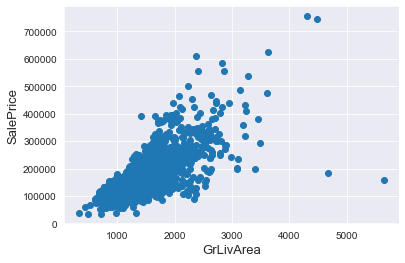

In [6]:
fig ,ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea', fontsize = 13)
plt.ylabel('SalePrice', fontsize = 13)
plt.show()

We can see ar the bottom right two with extremely large GrLivArea that are of a low price. THese values are huge outliers. Therefore, we can safely delete them.

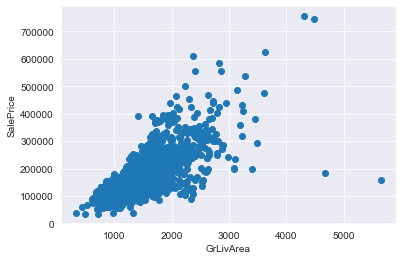

In [7]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 30000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

#### Note:
Outliers removal is note always safe. We decided to delete these two as they are very huge and really bad (extremely large areas for very low prices).

There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why, instead of removing them all, we will just manage to make some of our models robust on them. You can refer to the modelling part of this notebook for that.

### Target Variable

SalePrice is the variable we need to predict. So let's do some analysis on this variable first.

 
 mu = 180921.20 and sigma = 79415.29


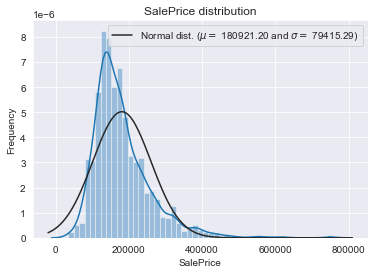

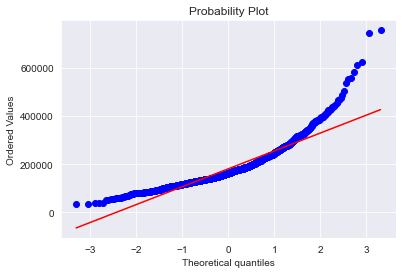

In [8]:
sns.distplot(train['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice']) # 표본집단 평균, 표본집단 표준편차
print(' \n mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
          loc = 'best') # $\mu=$ : 기호로 나타내줌
plt.ylabel('Frequency')
plt.xlabel('SalePrice')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data, we need to transform this variable and make it more normally distributed.

##### Log-transformation of the target variable


 mu = 12.02 and sigma = 0.40



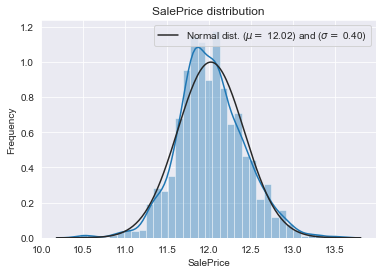

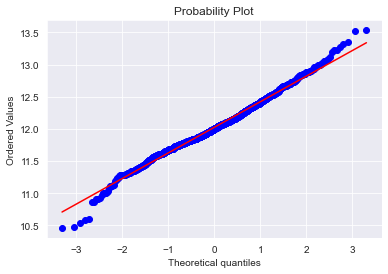

In [9]:
# We use the numpy function log1p which appies log(1+x) to all elemets of the column
train['SalePrice'] = np.log1p(train['SalePrice'])

# Check the new distribution
sns.distplot(train['SalePrice'], fit = norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f}) and ($\sigma=$ {:.2f})'.format(mu, sigma)],
          loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fit = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

The skew seems now corrected and the data appears more normally distributed

### Feature engineering

Let's first concatenate the train and test data in the same dataframe

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train['SalePrice'].values
all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print('all_data size is {}'.format(all_data.shape))

all_data size is (2919, 79)


### Missing data

In [11]:
all_data_na = (all_data.isnull().sum() / len(all_data) * 100)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]
missing_data = pd.DataFrame({'MIssing Ratio' : all_data_na})
missing_data.head(20)

,MIssing Ratio
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
FireplaceQu,48.647
LotFrontage,16.650
GarageFinish,5.447
GarageYrBlt,5.447
GarageQual,5.447
GarageCond,5.447


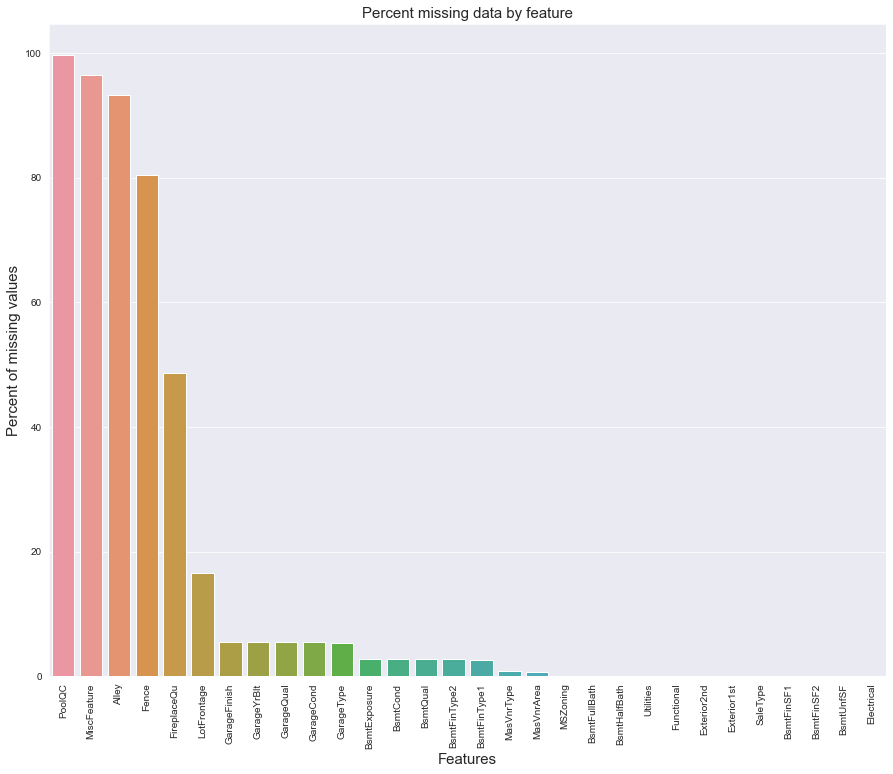

In [12]:
f, ax = plt.subplots(figsize = (15, 12))
plt.xticks(rotation = '90')
sns.barplot(all_data_na.index, all_data_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature', fontsize = 15)
plt.show()

### Data Correlation

<AxesSubplot:>

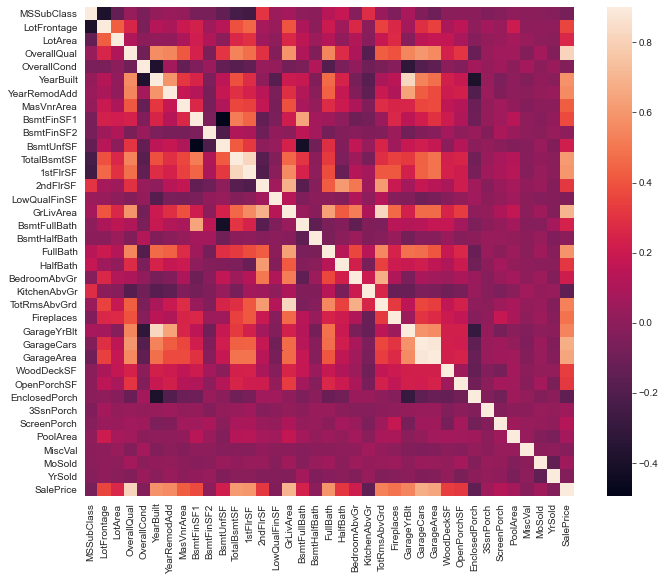

In [13]:
# Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.9, square = True)

### Imputing missing values

We impute them by proceeding sequentially through features with missing values

- PoolQC : data description says NA means No Pool. THat make sense given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general

In [14]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

- MiscFeature : data description says NA means no misc feature

In [15]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

- Alley : data description says NA means no alley access

In [16]:
all_data['Alley'] = all_data['Alley'].fillna('None')

- Fence : data description says NA means no fence

In [17]:
all_data['Fence'] = all_data['Fence'].fillna('None')

- FireplaceQu : data description says NA means no fireplace

In [18]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood, we can fill in missing values by the median LotFrontage of the neighborhood.

In [19]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

In [20]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- GarageYrBlt, GarageArea and GarageCars : Replacting missing data with 0 (Since No garage = no cars in such garage.)
numerical features이기 때문에 차고가 없을 경우 0으로 계산

In [21]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement

In [22]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.

In [23]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- MasVnrArea and MasVnrType : Na most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [24]:
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

- MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with RL

In [25]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities : For this categorical feature all records are AllPub, except for one NoSeWa and 2 NA. Since house with NoSeWa is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [26]:
all_data = all_data.drop('Utilities', axis = 1)

- Functional : data description says NA means typical

In [27]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

- Electrical : It has one NA value. Since this feature has mostly SBrkr, we can set that for the missing value.

In [28]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- KitchenQual : Only one NA value, and same as Electrical, we set TA (which is the most frequent) for the missing value in KitchenQual.

In [29]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string.

In [30]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- SaleType : Fill in againg with most frequent which is WD

In [31]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- MSSubClass : Na most likely means No building class. We can replace missing values with None

In [32]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna('None')

Is there any remaining missing value?

In [33]:
# Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data) * 100)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.

### More features engineering

#### Transforming some numerical variables that are really categorical

In [34]:
# MSSubClass = The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Label Encoding some categorical variables that may contain information in their ordering set.

In [35]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
       'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
       'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish',
       'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir',
       'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))
    
# shape
print('Shape all_data : {}'.format(all_data.shape))

Shape all_data : (2919, 78)


#### Adding one more important feature

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house.

In [36]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### Skewed features

In [37]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# Check the skew of all numerical featurs
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
print('\nSkew in numerical features : \n')
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness.head(10)


Skew in numerical features : 



,Skew
MiscVal,21.947
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
LandSlope,4.975
KitchenAbvGr,4.302
BsmtFinSF2,4.146
EnclosedPorch,4.004
ScreenPorch,3.947


#### Box Cox Transformation of highly skewed features

We use the scipy function boxcox1p which computed the Box-Cox transformation of 1 + x. Note that setting 'lambda = 0' is equivalent to log1p used above for the target variable.

In [38]:
skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    # all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
# all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


#### Getting dummy categorical features

In [39]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 221)


Getting the new train and test sets.

In [40]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modelling

#### Import libraries

In [41]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribute, we add then one line of code, in order to shuffle the dataset prior to cross-validation.

In [42]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = 'neg_mean_squared_error', cv = kf))
    return(rmse)

### Base models

#### LASSO Regression:
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [43]:
models = []
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))
models.append(lasso)

#### Elastic New Regression:
again made robust to outliers

In [44]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = .9, random_state = 3))
models.append(ENet)

#### Kernel Ridge Regression

In [45]:
KRR = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)
models.append(KRR)

#### Gradient Boosting Regression:
With huber loss that makes it robust to outliers

In [46]:
GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                  max_depth = 4, max_features = 'sqrt',
                                  min_samples_leaf = 15, min_samples_split = 10,
                                  loss = 'huber', random_state = 5)
models.append(GBoost)

#### XGBoost

In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468,
                            learning_rate = 0.05, max_depth = 3,
                            min_child_weight = 1.7817, n_estimators = 2200,
                            reg_alpha = 0.4640, reg_lambda = 0.8571,
                            subsample = 0.5213, silent = 1,
                            random_state = 7, nthread = -1)
models.append(model_xgb)

#### LightGBM


In [48]:
model_lgb = lgb.LGBMRegressor(objective = 'regression', num_leaves = 5,
                             learning_rate = 0.05, n_estimators = 720,
                             max_bin = 55, bagging_fraction = 0.8,
                             bagging_freq = 5, feature_fraction = 0.2319,
                             feature_fraction_seed = 9, bagging_seed = 9,
                             min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)
models.append(model_lgb)

#### Base models scores

Let's see how these base models perform on the data by evaluating the cross-validation rmse error

In [49]:
score = rmsle_cv(lasso)
print('\n Lasso score : {:.4f}, ({:.4f})\n'.format(score.mean(), score.std()))


 Lasso score : 0.1240, (0.0165)



In [50]:
score = rmsle_cv(ENet)
print('ElasticNet score : {:.4f}, {:.4f} \n'.format(score.mean(), score.std()))

ElasticNet score : 0.1240, 0.0165 



너무 길어서 for문으로 한번에 보기

In [51]:
for model in models:
    score = rmsle_cv(model)
    print('score : {:.4f}, {:.4f} \n'.format(score.mean(), score.std()))

score : 0.1240, 0.0165 

score : 0.1240, 0.0165 

score : 0.1262, 0.0127 

score : 0.1233, 0.0122 

[18:37:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:37:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:37:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might n

### Stacking models
#### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to leverage encapsulation and code reuse

#### Averaged base models class

In [67]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis = 1)

#### Averaged base models score

We just average four models here ENet, GBoost, KRR and lasso. Of course we could easily add more models in the mix.

In [69]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print('Averaged base models score : {:.4f} {:.4f} \n'.format(score.mean(), score.std()))

Averaged base models score : 0.1193 0.0144 



Wow! It seems even the simplest stacking approach really improve the score. This encourages us to go further and explore a less simple stacking approach.

### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:
1. Split the total training set into two disjoint sets (here train and holdout)
2. Train several base models on the fitst part (train)
3. Test these base models on the second part (holdout)
4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively. If we take for example a 5-fold stacking, we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations, that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in teh step 4.

For the prediction part, We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

The base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. THe entire training dataset is A+B (target variable y known) that we can split into train part (A) an holdout part (B). And the test dataset is C.

B1 (which is the prediction from the holdout part) is the new feature used to train the meta-model 3 and C1 (which is the prediction from the test dataset) is the meta-feature on which the final prediction is done.

#### Stacking averaged Models Class

In [134]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle = True, random_state = 156)
    
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the colned meta-model using the out-of-fold predictions as new feature
        # 예측값들을 input변수로 활용해서 train의 y 학습
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    # Do the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis = 1)
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

#### Stacking Averaged models Score

To make the two approaches comparable (by using the same number of models), we just average Enet KRR and Gboost, then we add lasso as meta-model.

In [120]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                meta_model = lasso)
score = rmsle_cv(stacked_averaged_models)
print('Stacking Averaged models score : {:.4f} {:.4f} \n'.format(score.mean(), score.std()))

Stacking Averaged models score : 0.1194 0.0143 



we get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add XGBoost and LightGBM to the StackedRegressor defined previously.

We first define a rmsle evaluation function

In [122]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

#### StackedRegressor:

In [137]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08067575941500754


#### XGBoost

In [138]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[19:42:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.07883366813411018


#### LightGBM

In [139]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.07430355082590832


In [152]:
 """ RMSE on the entire train data when averaging"""
    
print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred * 0.7 + xgb_train_pred * 0.15 + lgb_train_pred * 0.15))

RMSLE score on train data:
0.07701962822932529


#### Ensemble prediction:

In [155]:
ensemble = stacked_pred * 0.7 + xgb_pred * 0.15 + lgb_pred * 0.15

#### Submission

In [156]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub["SalePrice"] = ensemble
sub.to_csv('submission.csv', index = False)

### 요약
#### Feature engineering
feature에 대한 description을 통해 feature engineering을 진행. 해당 데이터 셋의 null data는 대부분 집에 해당 feature가 없는 경우. 이에 따라 null data는 'None' or '0'로 바꿔줌. 

#### Modelling
- 이상치에 민감한 모델의 경우(Lasso, ElasticNet) make_pipeline(RobustScaler())를 사용해 이상치에 대해 robust하게 바꿔줌.
- Adding a Meta-model이라는 방법을 사용해 meta feature을 따로 만들고 이에 대해 학습하도록 함. 
- training data에서 train part와 holdout part를 나눠서 kfold 만큼 base-model에서 학습 및 예측을 진행. holdout part에 대한 예측을 가지고 meta-feature로 사용해 meta-model을 학습함. base-model에서 training data set을 예측하고 이를 meta_model이 input 변수로 사용해 target 변수를 예측함.
- 그 밖에 XGBoost, LightGBM 등을 통해 predict한 값을 가지고 가중치를 달리해 ensemble이라는 변수로 합계를 냄.


<b> log1p, expm1 등 다양한 수학, 통계적인 함수가 포함되어있기에 추정예측을 하기위해선 이에 대한 지식이 필요한 것을 알 수 있음. 또한 validation fuction이나 stacking models class 등 다양한 함수 및 클래스를 만들어 효율적으로 학습, 예측, rmsle 등을 구함. 이를 참고하면 좋을 듯 </b>